In [1]:
"""
完整版和简化版的区别是有两个value模型
还有动态调整alpha
其他的和简化版一样"""

'\n完整版和简化版的区别是有两个value模型\n还有动态调整alpha\n其他的和简化版一样'

In [2]:
import gym


#定义环境
class MyWrapper(gym.Wrapper):
    def __init__(self):
        env = gym.make('Pendulum-v1', render_mode='rgb_array')
        super().__init__(env)
        self.env = env
        self.step_n = 0

    def reset(self):
        state, _ = self.env.reset()
        self.step_n = 0
        return state

    def step(self, action):
        state, reward, terminated, truncated, info = self.env.step(action)
        done = terminated or truncated
        self.step_n += 1
        if self.step_n >= 200:
            done = True
        return state, reward, done, info


env = MyWrapper()

env.reset()

array([ 0.47837758, -0.8781543 , -0.6795782 ], dtype=float32)

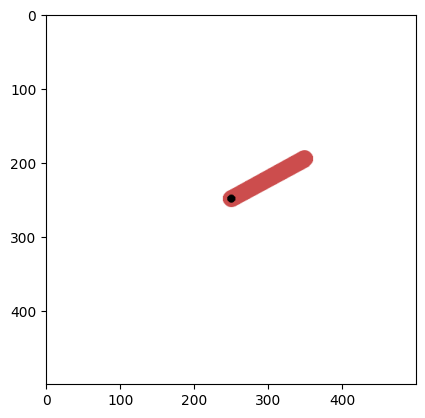

In [3]:
from matplotlib import pyplot as plt

%matplotlib inline


#打印游戏
def show():
    plt.imshow(env.render())
    plt.show()


show()

In [4]:
import torch


class ModelAction(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc_state = torch.nn.Sequential(
            torch.nn.Linear(3, 128),
            torch.nn.ReLU(),
        )
        self.fc_mu = torch.nn.Linear(128, 1)
        self.fc_std = torch.nn.Sequential(
            torch.nn.Linear(128, 1),
            torch.nn.Softplus(),
        )

    def forward(self, state):
        #[b, 3] -> [b, 128]
        state = self.fc_state(state)

        #[b, 128] -> [b, 1]
        mu = self.fc_mu(state)

        #[b, 128] -> [b, 1]
        std = self.fc_std(state)

        #根据mu和std定义b个正态分布
        dist = torch.distributions.Normal(mu, std)

        #采样b个样本
        #这里用的是rsample,表示重采样,其实就是先从一个标准正态分布中采样,然后乘以标准差,加上均值
        sample = dist.rsample()

        #样本压缩到-1,1之间,求动作
        action = torch.tanh(sample)

        #求概率对数
        log_prob = dist.log_prob(sample)

        #这个值描述动作的熵
        entropy = log_prob - (1 - action.tanh()**2 + 1e-7).log()
        entropy = -entropy

        return action * 2, entropy


model_action = ModelAction()

model_action(torch.randn(2, 3))

(tensor([[1.0771],
         [0.4553]], grad_fn=<MulBackward0>),
 tensor([[0.9284],
         [0.7199]], grad_fn=<NegBackward>))

In [5]:
class ModelValue(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.sequential = torch.nn.Sequential(
            torch.nn.Linear(4, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 1),
        )

    def forward(self, state, action):
        #[b, 3+1] -> [b, 4]
        state = torch.cat([state, action], dim=1)

        #[b, 4] -> [b, 1]
        return self.sequential(state)


model_value1 = ModelValue()
model_value2 = ModelValue()

model_value_next1 = ModelValue()
model_value_next2 = ModelValue()

model_value_next1.load_state_dict(model_value1.state_dict())
model_value_next2.load_state_dict(model_value2.state_dict())

model_value1(torch.randn(2, 3), torch.randn(2, 1))

tensor([[ 0.0308],
        [-0.1114]], grad_fn=<AddmmBackward>)

In [6]:
import random
import numpy as np


def get_action(state):
    state = torch.FloatTensor(state).reshape(1, 3)
    action, _ = model_action(state)
    return action.item()


get_action([1, 2, 3])

-0.753970205783844

In [7]:
#样本池
datas = []


#向样本池中添加N条数据,删除M条最古老的数据
def update_data():
    #初始化游戏
    state = env.reset()

    #玩到游戏结束为止
    over = False
    while not over:
        #根据当前状态得到一个动作
        action = get_action(state)

        #执行动作,得到反馈
        next_state, reward, over, _ = env.step([action])

        #记录数据样本
        datas.append((state, action, reward, next_state, over))

        #更新游戏状态,开始下一个动作
        state = next_state

    #数据上限,超出时从最古老的开始删除
    while len(datas) > 100000:
        datas.pop(0)


update_data()

len(datas), datas[0]

(200,
 (array([-0.6522397,  0.7580128,  0.9721634], dtype=float32),
  1.3092905282974243,
  -5.300698704036549,
  array([-0.7155343,  0.6985776,  1.7370665], dtype=float32),
  False))

In [8]:
#获取一批数据样本
def get_sample():
    #从样本池中采样
    samples = random.sample(datas, 64)

    #[b, 3]
    state = torch.FloatTensor([i[0] for i in samples]).reshape(-1, 3)
    #[b, 1]
    action = torch.FloatTensor([i[1] for i in samples]).reshape(-1, 1)
    #[b, 1]
    reward = torch.FloatTensor([i[2] for i in samples]).reshape(-1, 1)
    #[b, 3]
    next_state = torch.FloatTensor([i[3] for i in samples]).reshape(-1, 3)
    #[b, 1]
    over = torch.LongTensor([i[4] for i in samples]).reshape(-1, 1)

    return state, action, reward, next_state, over


state, action, reward, next_state, over = get_sample()

state[:5], action[:5], reward[:5], next_state[:5], over[:5]

(tensor([[-0.4384, -0.8988, -5.7731],
         [ 0.1364,  0.9906, -6.8175],
         [-0.3895,  0.9210, -7.6970],
         [-0.9368, -0.3498,  7.4263],
         [-0.9165, -0.4001, -7.4470]]),
 tensor([[-1.4290],
         [-0.8067],
         [-1.8733],
         [-1.8352],
         [-1.8813]]),
 tensor([[ -7.4338],
         [ -6.7046],
         [ -9.8124],
         [-13.2703],
         [-13.0022]]),
 tensor([[-0.7081, -0.7061, -6.6615],
         [ 0.4319,  0.9019, -6.1955],
         [-0.0357,  0.9994, -7.2873],
         [-0.7637, -0.6456,  6.8887],
         [-0.9999, -0.0116, -8.0000]]),
 tensor([[0],
         [0],
         [0],
         [0],
         [0]]))

In [9]:
from IPython import display


def test(play):
    #初始化游戏
    state = env.reset()

    #记录反馈值的和,这个值越大越好
    reward_sum = 0

    #玩到游戏结束为止
    over = False
    while not over:
        #根据当前状态得到一个动作
        action = get_action(state)

        #执行动作,得到反馈
        state, reward, over, _ = env.step([action])
        reward_sum += reward

        #打印动画
        if play and random.random() < 0.2:  #跳帧
            display.clear_output(wait=True)
            show()

    return reward_sum


test(play=False)

-1468.662637762065

In [10]:
def soft_update(model, model_next):
    for param, param_next in zip(model.parameters(), model_next.parameters()):
        #以一个小的比例更新
        value = param_next.data * 0.995 + param.data * 0.005
        param_next.data.copy_(value)


soft_update(torch.nn.Linear(4, 64), torch.nn.Linear(4, 64))

In [11]:
import math

#这也是一个可学习的参数
alpha = torch.tensor(math.log(0.01))
alpha.requires_grad = True

alpha

tensor(-4.6052, requires_grad=True)

In [12]:
def get_target(reward, next_state, over):
    #首先使用model_action计算动作和动作的熵
    #[b, 4] -> [b, 1],[b, 1]
    action, entropy = model_action(next_state)

    #评估next_state的价值
    #[b, 4],[b, 1] -> [b, 1]
    target1 = model_value_next1(next_state, action)
    target2 = model_value_next2(next_state, action)

    #取价值小的,这是出于稳定性考虑
    #[b, 1]
    target = torch.min(target1, target2)

    #exp和log互为反操作,这里是把alpha还原了
    #这里的操作是在target上加上了动作的熵,alpha作为权重系数
    #[b, 1] - [b, 1] -> [b, 1]
    target += alpha.exp() * entropy

    #[b, 1]
    target *= 0.99
    target *= (1 - over)
    target += reward

    return target


get_target(reward, next_state, over).shape

torch.Size([64, 1])

In [13]:
def get_loss_action(state):
    #计算action和熵
    #[b, 3] -> [b, 1],[b, 1]
    action, entropy = model_action(state)

    #使用两个value网络评估action的价值
    #[b, 3],[b, 1] -> [b, 1]
    value1 = model_value1(state, action)
    value2 = model_value2(state, action)

    #取价值小的,出于稳定性考虑
    #[b, 1]
    value = torch.min(value1, value2)

    #alpha还原后乘以熵,这个值期望的是越大越好,但是这里是计算loss,所以符号取反
    #[1] - [b, 1] -> [b, 1]
    loss_action = -alpha.exp() * entropy

    #减去value,所以value越大越好,这样loss就会越小
    loss_action -= value

    return loss_action.mean(), entropy


get_loss_action(state)

(tensor(0.2643, grad_fn=<MeanBackward0>),
 tensor([[ 0.7915],
         [-0.2055],
         [ 0.1777],
         [ 0.4656],
         [-0.4531],
         [ 0.4831],
         [ 0.7837],
         [ 0.5182],
         [ 0.5807],
         [-0.3043],
         [-0.0485],
         [ 0.5566],
         [-0.3825],
         [ 1.0466],
         [-0.5135],
         [-0.1574],
         [ 0.2675],
         [ 0.1302],
         [ 0.8504],
         [ 0.1966],
         [ 0.0937],
         [-0.4416],
         [ 1.2394],
         [ 1.6066],
         [ 1.3113],
         [ 1.0832],
         [ 0.0406],
         [ 1.2671],
         [-0.6935],
         [ 1.6894],
         [ 0.3122],
         [ 0.0357],
         [ 0.4353],
         [-0.2470],
         [ 0.3698],
         [ 0.3805],
         [ 1.7253],
         [-0.2183],
         [-0.3892],
         [-0.4130],
         [-0.0712],
         [ 1.6824],
         [-0.2828],
         [ 1.5402],
         [ 0.4781],
         [-0.5146],
         [ 0.9263],
         [ 0.9249]

In [14]:
def train():
    optimizer_action = torch.optim.Adam(model_action.parameters(), lr=3e-4)
    optimizer_value1 = torch.optim.Adam(model_value1.parameters(), lr=3e-3)
    optimizer_value2 = torch.optim.Adam(model_value2.parameters(), lr=3e-3)

    #alpha也是要更新的参数,所以这里要定义优化器
    optimizer_alpha = torch.optim.Adam([alpha], lr=3e-4)

    loss_fn = torch.nn.MSELoss()

    #训练N次
    for epoch in range(300):
        #更新N条数据
        update_data()

        #每次更新过数据后,学习N次
        for i in range(200):
            #采样一批数据
            state, action, reward, next_state, over = get_sample()

            #对reward偏移,为了便于训练
            reward = (reward + 8) / 8

            #计算target,这个target里已经考虑了动作的熵
            #[b, 1]
            target = get_target(reward, next_state, over)
            target = target.detach()

            #计算两个value
            value1 = model_value1(state, action)
            value2 = model_value2(state, action)

            #计算两个loss,两个value的目标都是要贴近target
            loss_value1 = loss_fn(value1, target)
            loss_value2 = loss_fn(value2, target)

            #更新参数
            optimizer_value1.zero_grad()
            loss_value1.backward()
            optimizer_value1.step()

            optimizer_value2.zero_grad()
            loss_value2.backward()
            optimizer_value2.step()

            #使用model_value计算model_action的loss
            loss_action, entropy = get_loss_action(state)
            optimizer_action.zero_grad()
            loss_action.backward()
            optimizer_action.step()

            #熵乘以alpha就是alpha的loss
            #[b, 1] -> [1]
            loss_alpha = (entropy + 1).detach() * alpha.exp()
            loss_alpha = loss_alpha.mean()

            #更新alpha值
            optimizer_alpha.zero_grad()
            loss_alpha.backward()
            optimizer_alpha.step()

            #增量更新next模型
            soft_update(model_value1, model_value_next1)
            soft_update(model_value2, model_value_next2)

        if epoch % 10 == 0:
            test_result = sum([test(play=False) for _ in range(10)]) / 10
            print(len(datas), test_result)


train()

400 -1604.85017631161
2400 -1071.0996546207134
4400 -339.77068327511023
6400 -351.9092491293369
8400 -152.16755011939136
10400 -177.98539578645585
12400 -337.44063662825766
14400 -110.50963497765144
16400 -189.16868175068169
18400 -148.17073024789696
20400 -176.88575617779603
22400 -182.79036443588683
24400 -181.06796321265892
26400 -188.9760013655387
28400 -158.87839279185877
30400 -124.40343072275884
32400 -152.06886636759577
34400 -165.40013577610188
36400 -110.36330266287152
38400 -147.15575107946006
40400 -225.78040577861393
42400 -149.32928740809842
44400 -288.7929535146113
46400 -569.2659909146579
48400 -170.76593353762905
50400 -158.67457005415264
52400 -159.36836374629578
54400 -85.92456050253662
56400 -161.2748416903053
58400 -169.7411981584319


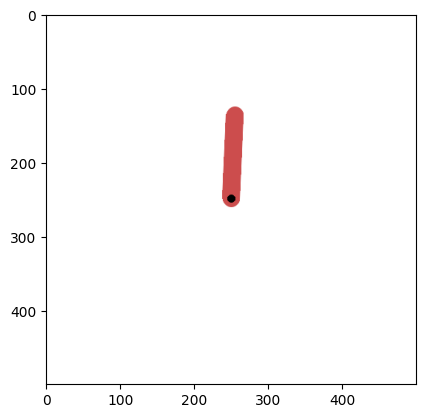

-127.48646701560392

In [15]:
test(play=True)